# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Загрузка данных и изучение общей информации

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pymystem3 import Mystem
import collections
from collections import Counter

In [2]:
data = pd.read_csv('/datasets/data.csv')
display(data.head(5))
data.info()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Вывод**

1)Уже при первом взгляде на таблицу заметны следующие проблемы:
- отрицательные числа в столбце days_employed
- слишком большие числа с столбце days_employed в группе пенсионеров
- разный регистр слов в столбце education
- информация показывает более двух тысяч пропусков в столбцах days_employed и total_income

2)Постановка задач исследования включает работу со столбцами:
- children
- family_status
- family_status_id
- debt
- total_income
- purpose

Однако все же можно "причесать" всю таблицу, приведя слова к единому регистру и по мере возможности разобравшись, что произошло в days_employed. 
Моя гипотеза: ошибки в регистре слов - следствие человеческого фактора. Клиенты вводили данные как попало. Ошибки в days_employed носят технический характер. Среднее значение рабочих дней таково, что пенсионеры проработали около тысячи лет на душу. Однако, если это не рабочие дни, а рабочие часы, ситуация становится более реалистичной.
Ситуация с пропусками в столбце с доходом хуже - надо понять, чем эти пропуски заполнить.


## Шаг 2. Предобработка данных

### Обработка пропусков

In [3]:
# выводим инфу о кол-ве пропусков
display(data.isna().sum())

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

<b>Промежуточный вывод:</b> пропуски в двух столбцах - days_employed и total_income, их количество одинаково, следовательно, можно предположить,что это одни и те же клиенты. Целесообразно заполнить пропуски в зависимости от типа дохода клиента

children               0
days_employed          0
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64


<AxesSubplot:title={'center':'Размах дней занятости'}>

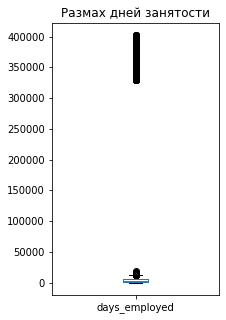

In [4]:
# уберем отрицательные значения в днях занятости
data['days_employed'] = abs(data['days_employed']) 

# заменим пропуски в днях занятости
data['days_employed'] = data.groupby('income_type')['days_employed'].apply(lambda x: x.fillna(x.median()))
print(data.isna().sum())

# визуализируем размах дней занятости
plt.title('Размах дней занятости')
data['days_employed'].plot(kind = 'box', figsize = (3,5))

<b>Промежуточный вывод:</b> в верхней границе четко видны аномалии. Моя гипотеза все еще предполагает ошибочный подсчет рабочих часов, а не дней. Заменим значения.

<AxesSubplot:title={'center':'Размах дней занятости после преобразований'}>

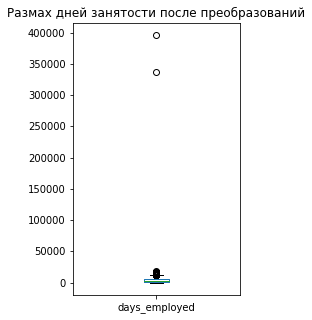

In [5]:
#создадим ф-цию превращения часов в дни
def hours_to_days(row):
    income_type = row['income_type']
    days_employed = row['days_employed']
    if income_type == 'пенсионер':
        days = int(days_employed // 24)
        return days
    else:
        return days_employed

#и применяем ее к каждой строке датафрейма
data['days_employed'] = data.apply(hours_to_days, axis = 1)

# визуализируем размах дней занятости
plt.title('Размах дней занятости после преобразований')
data['days_employed'].plot(kind = 'box', figsize = (3,5))

In [6]:
# вычислим категорию оставшихся аномалий
print(data.groupby('income_type')['days_employed'].median())
display(data[data['income_type'] == 'безработный'])

# удалим двух безработных
data.drop(data[data.income_type == 'безработный'].index, inplace = True)

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер           15217.000000
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64


,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
3133,1,337524.466835,31,среднее,1,женат / замужем,0,M,безработный,1,59956.991984,покупка жилья для сдачи
14798,0,395302.838654,45,Высшее,0,гражданский брак,1,F,безработный,0,202722.511368,ремонт жилью


In [7]:
# поправим индексацию и проверим данные
data = data.reset_index(drop =True)
data.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,14177.000000,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


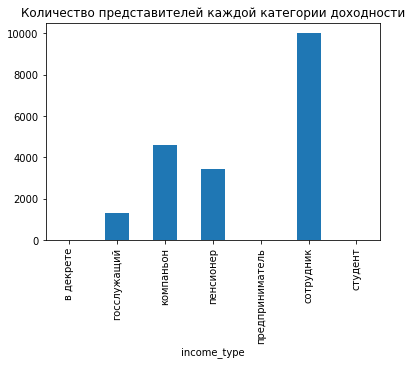

Text(0.5, 1.0, 'Медианный доход представителей каждой категории')

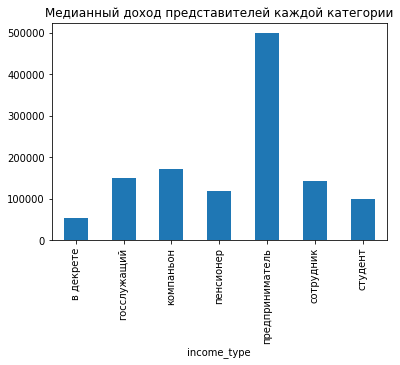

In [8]:
#посмотрим на количество всех лиц по категориям дохода
data.groupby('income_type')['total_income'].count().plot(kind = 'bar')
plt.title('Количество представителей каждой категории доходности')
plt.show()

#и на медианный доход по категориям
data.groupby('income_type')['total_income'].median().plot(kind = 'bar')
plt.title('Медианный доход представителей каждой категории')

<b>Промежуточный вывод:</b> предприниматели, декретные матери и студенты представляют слишком мелкую выборку, которая даже не видна на графике номер 1. Зато доход у них есть, причем у предпринимателей - огромный. Выглядит скорее как выброс, а не как тенденция, поэтому от этих данных лучше избавиться - они слишком незначительны по количеству, но могут сильно сдвинуть результаты.

In [9]:
# удалим аномальные и малозначимые категории
employments = ['предприниматель', 'в декрете', 'студент']
data = data[~data.income_type.isin(employments)]

# проверим изменения
data['income_type'].value_counts()

сотрудник      11119
компаньон       5085
пенсионер       3856
госслужащий     1459
Name: income_type, dtype: int64

Осталось заполнить пропуски с доходом

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64


Text(0.5, 1.0, 'Доход разных категорий граждан')

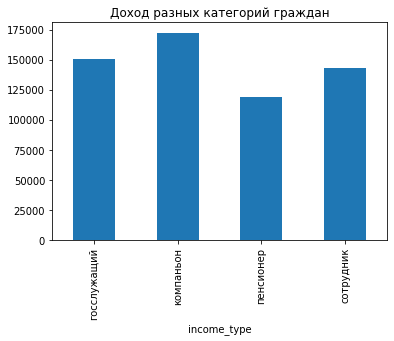

In [10]:
# заменим пропуски в днях занятости
data['total_income'] = data.groupby('income_type')['total_income'].apply(lambda x: x.fillna(x.median()))
print(data.isna().sum())

# визуализируем данные 
data.groupby('income_type')['total_income'].median().plot(kind = 'bar')
plt.title('Доход разных категорий граждан')

In [11]:
# убедимся, что пропусков более нет
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Вывод**

Все пропуски из таблицы убраны, но проблемы все еще остались. 
Проблемы в столбцах:
- education
- days_employed
- total_income

Нужно:
- привести значения в education к единому регистру
- заменить данные в столбце days_employed на int (убрать минусы, повысить читаемость)
- в столбце total_income привести все значения к целочисленным, повысив читаемость кода

### Замена типа данных

In [12]:
#меняем данные float в income_type и days_employed  на целочисленные 
data['total_income'] = data['total_income'].astype('int')
data['days_employed'] = data['days_employed'].astype('int')
data.head(3)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья


**Вывод**

Теперь таблица более читаема. Целочисленные значения содержатся в столбцах с общих доходом и днями занятости. 
Осталось привести в порядок столбец с образованием - об этом ниже.

### Обработка дубликатов

In [13]:
columns = ['children', 'gender', 'education', 'education_id', 
           'family_status', 'family_status_id', 'income_type', 'purpose', 'debt']
for column in columns: 
    display(data[column].value_counts().head(10))

# заменим аномальные значения и приведем строки к единому регистру
data = data[data['gender'] != 'XNA']
data['education'] = data.education.str.lower()
data['children'] = data['children'].replace([-1, 20],[1,2])


 0     14145
 1      4817
 2      2054
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

F      14233
M       7285
XNA        1
Name: gender, dtype: int64

среднее                13749
высшее                  4715
СРЕДНЕЕ                  771
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   267
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
Name: education, dtype: int64

1    15231
0     5256
2      744
3      282
4        6
Name: education_id, dtype: int64

женат / замужем          12377
гражданский брак          4175
Не женат / не замужем     2812
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

0    12377
1     4175
4     2812
3     1195
2      960
Name: family_status_id, dtype: int64

сотрудник      11119
компаньон       5085
пенсионер       3856
госслужащий     1459
Name: income_type, dtype: int64

свадьба                                  797
на проведение свадьбы                    776
сыграть свадьбу                          774
операции с недвижимостью                 676
покупка коммерческой недвижимости        664
операции с жильем                        653
покупка жилья для сдачи                  652
операции с коммерческой недвижимостью    651
жилье                                    647
покупка жилья                            647
Name: purpose, dtype: int64

0    19780
1     1739
Name: debt, dtype: int64

In [14]:
# ищем дубликаты
print(data.duplicated().sum())

# и удаляем их
data = data.drop_duplicates().reset_index(drop = True)

#проверяем датасет
print(data.duplicated().sum())

71
0


**Вывод**

Сначала мы привели [education] к единому регистру, устраненили неизвестный пол и внесли исправления в кол-во детей. После этого выявили 71 дубликат и удалили все.
Таблица полностью заполнена, приведена к единому стилю и очищена от дубликатов.
Осталось создать классификацию клиентов по целям кредита.

### Лемматизация

In [15]:
# лемматизируем цели кредита
m = Mystem()
lemmas = []
for purpose in data['purpose']:
    lemmas.append(m.lemmatize(purpose))

#в датафрейме создаем столбец с леммами, он потребуется для категоризации
data['lemmas'] = lemmas
data['lemmas'].head(5)

0                 [покупка,  , жилье, \n]
1       [приобретение,  , автомобиль, \n]
2                 [покупка,  , жилье, \n]
3    [дополнительный,  , образование, \n]
4               [сыграть,  , свадьба, \n]
Name: lemmas, dtype: object

In [16]:
# выводим топ-10 значений
lemm_list = []
for row in lemmas:
    lemm_list += row

frequencies = Counter(lemm_list)
display(frequencies.most_common(10))

[(' ', 33559),
 ('\n', 21447),
 ('недвижимость', 6348),
 ('покупка', 5894),
 ('жилье', 4458),
 ('автомобиль', 4305),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2323)]

<b>Промежуточный вывод:</b> топовые смысловые категории: жилье/недвижимость, автомобиль, образование, свадьба

In [17]:
# разбиваем цели кредита на 4 категории
# каждой присваиваем номер 

purpose_id = []
for row in data['lemmas']:
    if 'автомобиль' in row:
        purpose_id.append(0)
    elif 'образование' in row:
         purpose_id.append(1)
    elif 'свадьба' in row:
         purpose_id.append(2)
    elif 'жилье' or 'недвижимость' in row:
         purpose_id.append(3)

data['purpose_id'] = purpose_id

#столбец с леммами больше не нужен - его можно удалить
data = data.drop('lemmas', axis=1)

#проверяем датафрейм
display(data.head(3))

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_id
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,3
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,0
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,3


**Вывод**

В датафрейме появился столбец с идентификатором кредитных целей. Это упростит нам работу.

### Категоризация данных

<AxesSubplot:title={'center':'Зависимость наличия долга от типа занятости'}, xlabel='debt,income_type'>

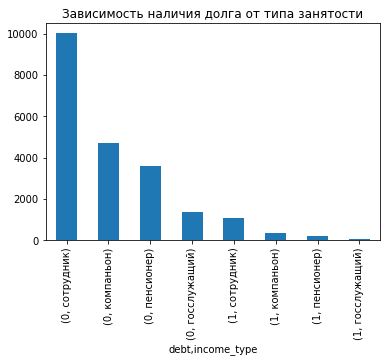

In [18]:
data.groupby('debt')['income_type'].value_counts().plot(kind = 'bar',
                                                        title = 'Зависимость наличия долга от типа занятости')

<b>Промежуточный вывод:</b> не-должников больше, среди них лидеры - сотрудники. Впрочем, по количеству долгов лидируют они же. Остальные категории также идут ровно - где больше не должников, там больше должников, соответственно. Здесь, скорее всего, играет фактор численности представителей.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Доля лиц, у которых есть долг и нет детей, составляет: 0.6112708453133985 среди всех должников
Доля лиц, у которых нет долга и нет детей, составляет: 0.6607976456261416 среди всех не должников


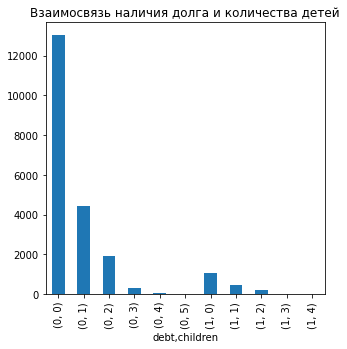

In [19]:
data.groupby('debt')['children'].value_counts().plot(kind = 'bar', title = 'Взаимосвязь наличия долга и количества детей',
                                                     figsize = (5,5))

# посмотрим на долевые соотношения должников с детьми и без
print('Доля лиц, у которых есть долг и нет детей, составляет:', 
      data[(data['debt']!=0) & (data['children'] ==0)]['children'].count() / data[data['debt']!=0]['children'].count(), 'среди всех должников')

print('Доля лиц, у которых нет долга и нет детей, составляет:', 
      data[(data['debt']==0) & (data['children'] ==0)]['children'].count() / data[data['debt']==0]['children'].count(), 'среди всех не должников')

**Вывод**

Взаимосвязи практически нет.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

<AxesSubplot:title={'center':'Взаимосвязь наличия долга и семейного положения'}, xlabel='debt,family_status_id'>

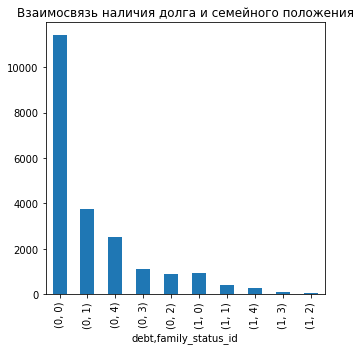

In [20]:
data.groupby('debt')['family_status_id'].value_counts().plot(kind = 'bar', title = 'Взаимосвязь наличия долга и семейного положения',
                                                     figsize = (5,5))

<AxesSubplot:title={'center':'Доля должников по различным категориям граждан'}>

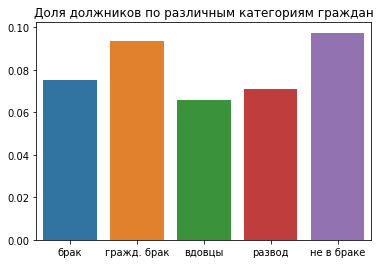

In [21]:
# подсчитаем соотношение должников по категориям
columns = ['брак', 'гражд. брак', 'вдовцы', 'развод', 'не в браке']
results = []
for i in range(5):
    results.append(data[(data['debt']==1) & (data['family_status_id'] == i)]['family_status_id'].count() /
                   data[(data['debt']>=0) & (data['family_status_id'] == i)]['family_status_id'].count())

# визуализируем данные
plt.title('Доля должников по различным категориям граждан')
sns.barplot(x = columns, y = results)

**Вывод**

Взаимосвязь между семейным положением и уплатой долга есть. Самая надежная категория плательщиков - вдовцы, за ними следуют люди в разводе, после этого - граждане, состоящие в браке. Две наиболее рискованные категории - лица, состоящие в гражданском браке, и не состоящие в браке вовсе.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

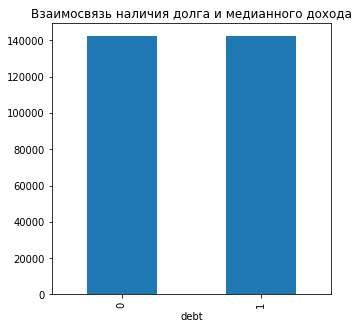

<AxesSubplot:title={'center':'Взаимосвязь наличия долга и среднего дохода'}, xlabel='debt'>

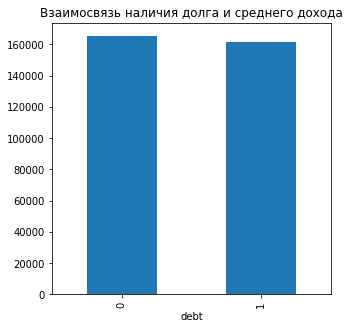

In [22]:
data.groupby('debt')['total_income'].median().plot(kind = 'bar', title = 'Взаимосвязь наличия долга и медианного дохода',
                                                     figsize = (5,5))
plt.show()
data.groupby('debt')['total_income'].mean().plot(kind = 'bar', title = 'Взаимосвязь наличия долга и среднего дохода',
                                                     figsize = (5,5))

**Вывод**

Зависимости почти нет.

- Как разные цели кредита влияют на его возврат в срок?

<AxesSubplot:title={'center':'Доля должников по различным категориям целей кредита'}>

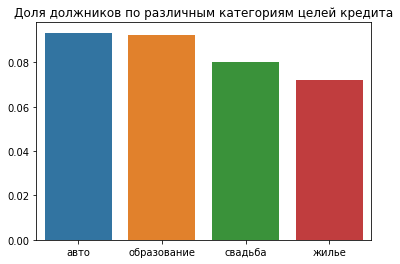

In [23]:
#с помощью цикла пройдем по категориям целей кредита
#и соберем сведения о должниках, не должниках и проценте невыплат
# подсчитаем соотношение должников по категориям
columns = ['авто', 'образование', 'свадьба', 'жилье']
results = []
for i in range(4):
    results.append(data[(data['debt']==1) & (data['purpose_id'] == i)]['purpose_id'].count() /
                   data[(data['debt']>=0) & (data['purpose_id'] == i)]['purpose_id'].count())

# визуализируем данные
plt.title('Доля должников по различным категориям целей кредита')
sns.barplot(x = columns, y = results)

**Вывод**

Самые добросовестные плательщики - те, которые берут кредит на жилье и свадьбы. Процент невыплат среди кредитов в категории "авто" и "образование" выше.
Зависимость возврата кредита в срок от его цели прослеживается.

## Шаг 4. Общий вывод

На основании анализа таблицы и составленных диаграмм, можно сделать следующие выводы:

- уровень дохода клиента и наличие детей незначительно влияют на возможность невыплаты клиентом долга
- лица, не состоящие в браке или состоящие в гражданском браке, с большим шансом не выплатят кредит, чем лица, состоящие или состоявшие в браке (разведенные или вдовцы)
- наиболее "безопасно" выдавать кредиты на жилье или свадьбы, кредиты на покупку авто или получение образования с большим шансом не будут выплачены.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл;
- [x]  файл изучен;
- [x]  определены пропущенные значения;
- [x]  заполнены пропущенные значения;
- [x]  есть пояснение, какие пропущенные значения обнаружены;
- [x]  описаны возможные причины появления пропусков в данных;
- [x]  объяснено, по какому принципу заполнены пропуски;
- [x]  заменен вещественный тип данных на целочисленный;
- [x]  есть пояснение, какой метод используется для изменения типа данных и почему;
- [x]  удалены дубликаты;
- [x]  есть пояснение, какой метод используется для поиска и удаления дубликатов;
- [x]  описаны возможные причины появления дубликатов в данных;
- [x]  выделены леммы в значениях столбца с целями получения кредита;
- [x]  описан процесс лемматизации;
- [x]  данные категоризированы;
- [x]  есть объяснение принципа категоризации данных;
- [x]  есть ответ на вопрос: "Есть ли зависимость между наличием детей и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между семейным положением и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?";
- [x]  есть ответ на вопрос: "Как разные цели кредита влияют на его возврат в срок?";
- [x]  в каждом этапе есть выводы;
- [x]  есть общий вывод.